In [27]:
# This function was borrowed in part from code written by J. Cordes in 2018 
# for a KDI DISS & RISS simulation

import numpy as np
from math import *
from pylab import *
from scipy import *
from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt

In [28]:
def _gen_powlaw_phase_screen(si, phiF, rF, inner, outer, dx, dy, xwidth, \
                           ywidth, apply_outer=False, apply_inner=False, normfres=True, debug=False):
    
    """
    Generates npoints of a realization of power-law noise with unit 
    variance with spectral index si and inner and outer scales as 
    specified for a sample interval dx. 


    input:
    si = spectral index of power-law wavenumber spectrum
    phiF = rms phase at Fresnel scale (rad)
        length scales: all dimensionless:
        rF      = Fresnel scale
        inner, outer    = inner and outer scales
        dx, dy      = sample intervals
        xwidth, ywidth  = screen extent
    logical:
            normfres    = True implies normalization to phiF

        Definition of Fresnel scale: r_F^2 = \lambda D / 2\pi

    returns:
       xvec, yvec, xseries, xseries_norm, qxvec, qyvec, qshape
       (xvec, yvec) coordinates perpendicular to line of sight 
       xseries = screen phase 
       xseries_norm = screen phase scaled to input rms phase on Fresnel scale
       qxvec, qyvec  = wavenumber axes
       qshape = sqrt(shape of wavenumber spectrum)

    """

    nx = int(xwidth/dx)
    ny = int(ywidth/dy)
    print('targeted number of x,y samples = ', nx,ny)
    xvec = (np.arange(0.,nx)-nx/2+1)*dx
    yvec = (np.arange(0.,ny)-ny/2+1)*dy

    dqx = 2.*np.pi / xwidth
    dqy = 2.*np.pi / ywidth
    qmaxx = (2.*np.pi) / (2.*dx)
    qmaxy = (2.*np.pi) / (2.*dy)

    nqx = 2*int(qmaxx/dqx)
    nqy = 2*int(qmaxy/dqy)
    print('targeted number of q samples = ', nqx, nqy) 
    if nqx != nx: 
        print("Forcing nqx = nx = ", nx)
        nqx = nx
    if nqy != ny: 
        print("Forcing nqy = ny = ", ny)
        nqy = ny
    qxvec = (np.arange(0.,nqx)-nqx//2+1)*dqx
    qxvec = np.roll(qxvec,nqx//2+2)
    qyvec = (np.arange(0.,nqy)-nqy//2+1)*dqy
    qyvec = np.roll(qyvec,nqy//2+2)

    qin = 2.*np.pi / inner
    qout = 2.*np.pi / outer
    qshape = np.zeros((nqx, nqy))
    qshape_rolloff = np.zeros((nqx, nqy))      # for upper wavenumber rolloff
    
    if apply_outer:
        print("Applying outer-scale rolloff")
    
    # Put in upper wavenumber cutoff at array size
    # to avoid aliasing
    qmax = qxvec.max()/2.
    for i, qxi in enumerate(qxvec):
        for j, qyj in enumerate(qyvec):
            qsq = qxi**2 + qyj**2
            qshape[i,j] = (qout**2 + qsq)**(-si/4.) * np.exp(-qsq/(2.*qmax**2)) 
            qshape_rolloff[i,j] = np.exp(-qsq / (2.*qin**2))
            if apply_outer: 
                
                qshape[i,j] *= np.exp(-qout**2 / (2.*qsq))

    npoints = np.size(qshape)
    print(si, inner, outer, dx, npoints)
    print(dqx, dqy, qin, qout)

    xformr=np.random.randn(nqx, nqy)*qshape
    xformi=np.random.randn(nqx, nqy)*qshape
    xform = xformr + 1j*xformi
    spectrum = abs(xform)**2
    xseries = np.real(np.fft.ifft2(xform))

    # Normalization factor needs to be calculated on pure power-law spectrum
    # before any rolloff at the refraction scale
    if normfres:
        frindx = int(rF/dx)
        x1dcut = xseries[0,:]
        var_fres_in = np.var(x1dcut[0:np.size(x1dcut)-frindx]-x1dcut[frindx:])
        norm_factor = phiF / np.sqrt(var_fres_in)
        xseries_norm = xseries * norm_factor
        xn1dcut = xseries_norm[0,:]
        var_fres_out = np.var(xn1dcut[0:np.size(xn1dcut)-frindx]-xn1dcut[frindx:])
        print("index of fresnel scale = ", frindx)
        print(var_fres_in, var_fres_out)

    # applying inner scale now an option with apply_inner = True (2015 Dec 28)
    # needs to be applied *after* normalization!
    # now need to recalculate the realization and apply norm_factor 
    if apply_inner: 
        print("Applying inner-scale rolloff")

        # recalculate 
        xform *= qshape_rolloff
        spectrum = abs(xform)**2
        xseries = np.real(ifft2(xform))
        xseries_norm = xseries * norm_factor

    return xvec, yvec, xseries, xseries_norm, qxvec, qyvec, qshape

targeted number of x,y samples =  127 127
targeted number of q samples =  126 126
Forcing nqx = nx =  127
Forcing nqy = ny =  127
Applying outer-scale rolloff
2.6666666666666665 1.0 5.0 0.15707963267948966 16129
0.3141592653589793 0.3141592653589793 6.283185307179586 1.2566370614359172
index of fresnel scale =  6
2.9884444737319264e-07 0.9999999999999999
Applying inner-scale rolloff


<ipython-input-28-a7a503cf6649>:76: RuntimeWarning: divide by zero encountered in double_scalars
  qshape[i,j] *= np.exp(-qout**2 / (2.*qsq))


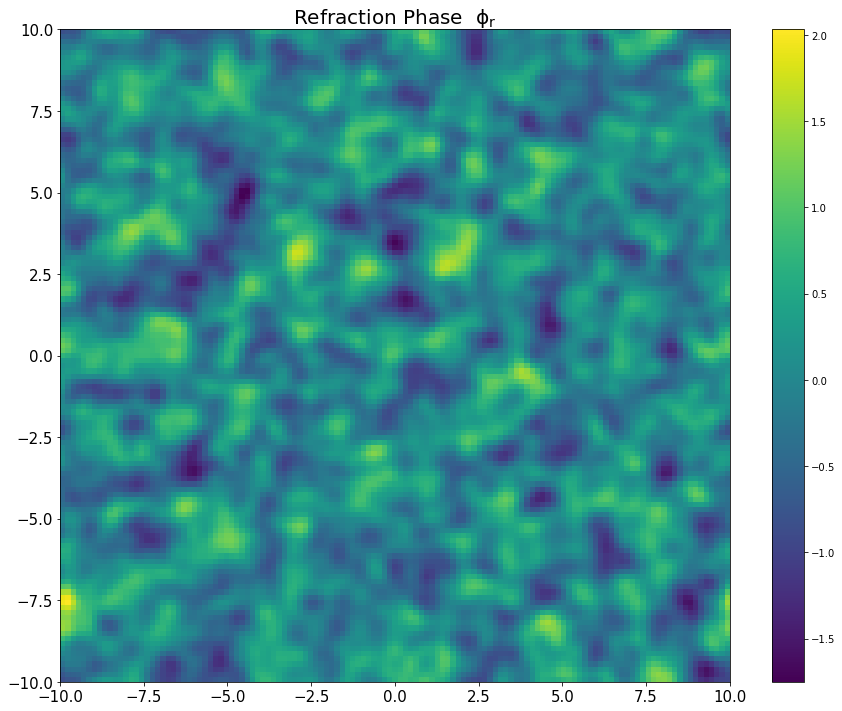

In [29]:
si_kol_r = 8./3.
phiF_r = 1.
rF = 1. #Fresnel scale by definition
xwidth = ywidth = 20.
xmax = xwidth/2
ymax = ywidth/2

# get refraction phase screen:
# define refraction scale using Fresnel phase for refracting screen
# since we want to control refraction separately from diffraction

#lr = rF * max(1., phiF_r)
lscale_index = 2. / (si_kol_r-2.)
u = max(1., phiF_r**lscale_index)
ld = rF / u
lr = rF * u

inners = lr
outers = xmax/2.

# Nyquist sample the Fresnel function and resolve the diffraction scale:
dx = min(pi * rF**2 / xmax, ld/2.)
dy = min(pi * rF**2 / ymax, ld/2.)
dx /= 2
dy /= 2

xvec, yvec, xseries, phir, qxvec, qyvec, qshape = \
   _gen_powlaw_phase_screen(si_kol_r,phiF_r,rF,inners,outers, \
   dx,dy,xwidth,ywidth,apply_outer=True,apply_inner=True,normfres=True)


fig = plt.figure(figsize = (15, 12))
plt.imshow(phir, aspect='auto', origin='lower', extent=(-xmax, xmax, -ymax, ymax), interpolation='nearest')
plt.tick_params(axis='x', labelbottom='off')
plt.title(r'$\rm Refraction \  Phase \ \  \phi_r$', fontsize = 20)
plt.tick_params(axis='both', labelsize='15')
plt.colorbar()
plt.show()